In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

Training and validation datasets

In [2]:
train_dataset = image_dataset_from_directory(
    "dataset/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  
)

Found 956 files belonging to 15 classes.


In [3]:
val_dataset = image_dataset_from_directory(
    "dataset/validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 480 files belonging to 15 classes.


Normalizing pixel values

In [5]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  
    return image, label

In [6]:
train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)

Data Augmentation

In [7]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [8]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

In [9]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Data Analyzation

In [10]:
import os
import matplotlib.pyplot as plt

In [11]:
train_dir = "dataset/train"
classes = os.listdir(train_dir)

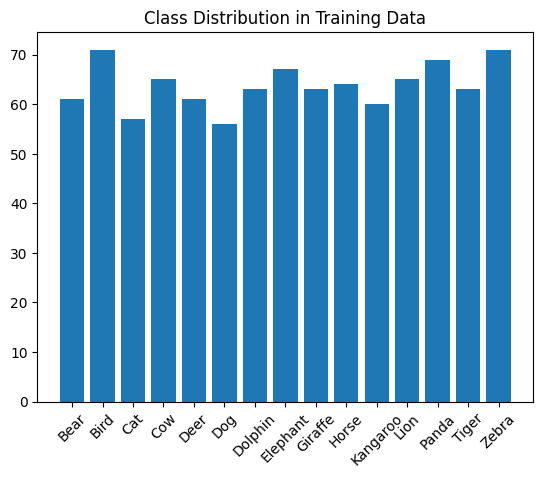

In [12]:
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]
plt.bar(classes, class_counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

Model Development using ResNet50

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [20]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Fine-Tuning Transfer Learning

In [21]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training the model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.0664 - loss: 2.8766 - val_accuracy: 0.0667 - val_loss: 2.7721
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.0776 - loss: 2.8615 - val_accuracy: 0.0667 - val_loss: 2.7434
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.1173 - loss: 2.7637 - val_accuracy: 0.0667 - val_loss: 2.7308
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.0896 - loss: 2.7527 - val_accuracy: 0.0667 - val_loss: 2.7313
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1415 - loss: 2.6589 - val_accuracy: 0.0667 - val_loss: 2.7283
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1569 - loss: 2.6207 - val_accuracy: 0.0896 - val_loss: 2.7200
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1438 - loss: 2.6094 - val_accuracy: 0.1063 - val_loss: 2.7130
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.1194 - loss: 2.5905 - val_accuracy: 0.1229 - val_loss:

Model Evaluation

In [26]:
test_dataset = image_dataset_from_directory(
    "dataset/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 508 files belonging to 15 classes.


In [27]:
test_dataset = test_dataset.map(normalize_image)

Test Accuracy

In [28]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2247 - loss: 2.3731
Test Accuracy: 0.23


Classification Report

In [29]:
from sklearn.metrics import classification_report

In [30]:
y_true = [] 
y_pred = [] 

In [31]:
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

        Bear       0.25      0.06      0.10        32
        Bird       0.25      0.09      0.13        34
         Cat       1.00      0.03      0.06        34
         Cow       0.45      0.53      0.49        34
        Deer       0.00      0.00      0.00        34
         Dog       0.16      0.18      0.17        34
     Dolphin       0.14      0.65      0.23  

d:\mlops\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mlops\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mlops\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Deployment

In [33]:
model.save("animal_classifier_model.keras")